In [198]:
import pandas as pd
import gensim
from konlpy.tag import Komoran
import sentencepiece as spm
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [199]:
plt.rcParams['axes.unicode_minus'] = False
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(context='notebook',
              style='darkgrid',
              palette='pastel',
              font='Malgun Gothic',
              rc=custom_params)

In [200]:
# 자동차 사전 데이터 불러오기
def load_car_dic():
    car_dic_file = open('carDic.txt','r',encoding='utf8')
    car_dic = set(car_dic_file.read().split('\n'))
    return car_dic

car_dic = load_car_dic()
print(len(car_dic))

1433


In [201]:
memo_data = pd.read_csv('car_inspect_info.tsv', sep='\t', lineterminator='\r')
memo_data = memo_data.drop(columns=['inspect_id', 'car_id']) # drop columns
memo_data = memo_data.dropna() # drop nan row
print(len(memo_data))
memo_data.head()

254142


,inspect_at,inspect_type,price,description
0,2020-03-09,타이어수리(후우),6600.0,조수석뒤타이어 현장펑크수리
1,2020-01-07,미션오일,120000.0,단양애니카_미션오일 교환
2,2020-01-14,점화플러그,60000.0,당진세계모터스_점화플러그 교환
3,2020-01-14,브레이크액,50000.0,당진세계모터스-브레이크오일 교환
4,2020-01-06,브레이크액,40000.0,당진세계모터스_브레이크오일 교환


### sentences 전처리

In [202]:
with open('car_info_description.txt','w',encoding='utf8') as w, open('KCC150_100k.txt','r',encoding='utf8') as corpus:
    w.write('\n'.join(memo_data['description']))
    for idx, snt in enumerate(corpus.readlines()):
        w.write(snt)

In [203]:
spm.SentencePieceTrainer.Train(f'--input=car_info_description.txt --model_prefix=description --vocab_size=6000')
sp = spm.SentencePieceProcessor()
vocab_file = 'description.model'
sp.load(vocab_file)

True

In [204]:
def to_token(df, col):

    morph_description = []
    for _, row in df.iterrows():
        memo = row[col]
        sp_out = sp.encode_as_pieces(memo.replace('_',' ').replace('-',' ').replace('/',' ').replace('ㄴ',' ').replace('#',' ').replace('=',' ').replace(')',' ) ').replace('(',' ( '))
        morph_description.append(' '.join([token.replace('▁','') for token in sp_out]))

    df["subword_description"] = morph_description
    return df

memo_data = to_token(memo_data, "description")
memo_data.head()

,inspect_at,inspect_type,price,description,subword_description
0,2020-03-09,타이어수리(후우),6600.0,조수석뒤타이어 현장펑크수리,조수석 뒤 타이어 현장 펑크수리
1,2020-01-07,미션오일,120000.0,단양애니카_미션오일 교환,단 양 애 니 카 미션오일 교환
2,2020-01-14,점화플러그,60000.0,당진세계모터스_점화플러그 교환,당진세계모터스 점화플러그 교환
3,2020-01-14,브레이크액,50000.0,당진세계모터스-브레이크오일 교환,당진세계모터스 브레이크오일 교환
4,2020-01-06,브레이크액,40000.0,당진세계모터스_브레이크오일 교환,당진세계모터스 브레이크오일 교환


In [205]:
sentences = list(memo_data['subword_description'])
sentences = [line.split() for line in sentences]

#### FastText 모델사용

In [206]:
model = gensim.models.fasttext.FastText(vector_size=300, window=5, min_count=1)
model.build_vocab(sentences)
model.train(sentences, total_examples=len(sentences), epochs=10)

(13145672, 17214490)

In [207]:
model.wv.most_similar('타이어', topn=10)

[('앞타이어', 0.8601456880569458),
 ('이어', 0.8461170196533203),
 ('타이어펑크', 0.8429301977157593),
 ('후좌타이어', 0.8218088746070862),
 ('전좌타이어', 0.79749596118927),
 ('후우타이어', 0.7799896597862244),
 ('전우타이어', 0.7774056792259216),
 ('김대중타이어', 0.6887706518173218),
 ('타이어교체', 0.6786057949066162),
 ('타이어공기압', 0.671827495098114)]

In [208]:
model.wv.most_similar('경고등', topn=10)

[('통합경고등', 0.7958380579948425),
 ('공기압경고등', 0.7577552199363708),
 ('경고', 0.6727164387702942),
 ('라이트경고등', 0.6549990773200989),
 ('엔진체크등', 0.6381188631057739),
 ('고장코드', 0.5908607244491577),
 ('기억', 0.584080696105957),
 ('체크', 0.5492510199546814),
 ('코드', 0.49532192945480347),
 ('과거', 0.49403950572013855)]

In [209]:
# 유사도가 평균값 이상인 것만 선택 하는 함수
def exclusion(word_list):

    count = sum([score for _, score in word_list])
    avg = count / len(word_list)
  
    up_word = []
    for w, s in word_list:
        if s > avg:
            up_word.append(w)
  
    return up_word

In [210]:
def re_ranking(word_list):

    max_word = (None, -99)
    for word in word_list:
        if word in mapping_table:
            word = mapping_table.get(word)

        if subword_counter[word] > max_word[1]:
            max_word = (word, subword_counter[word])

    return max_word[0]

In [211]:
def noun_phrase(words):
    result = []

    for index, token in enumerate(words):
        if (token in car_dic) or (token in category):
            
            if (''.join(words[index : index +2]) in car_dic) or (''.join(words[index : index +2]) in category):
                result.append(''.join(words[index : index +2]))
            
            result.append(token)
    return result

def find_category(row):
   
    line = row['description'].replace('_',' ').replace('-',' ').replace('/',' ').replace('ㄴ',' ').replace('#',' ').replace('=',' ').replace(')',' ) ').replace('(',' ( ')
    car_token = noun_phrase(line.upper().split())
 
    car_token.extend(noun_phrase(row['subword_description'].upper().split()))
    return set(car_token)

In [212]:
light = model.wv.most_similar('라이트', topn=20)
light_word = exclusion(light)
light = model.wv.most_similar('전구', topn=20)
light_word.extend(exclusion(light))

light_word.append('라이트')
light_word.append('전구')

light_word = set(light_word)

error = model.wv.most_similar('경고등', topn=10)
error_word = exclusion(error)
error_word.append('경고등')

print(light_word)
print('')
print(error_word)

{'라이트전구', '하향등', '데이라이트', '브레이크전구', '브레이크등', '라이트', '헤드라이트', '안개등', '전조등', '미등', '후미등', '주행등', '주간주행등', '방향지시등', '전구', '백색더블'}

['통합경고등', '공기압경고등', '경고', '라이트경고등', '엔진체크등', '경고등']


In [213]:
# 매핑 테이블 작성
mapping_table = {'내비게이션':'네비게이션', '내비':'네비게이션', '네비':'네비게이션', \
                  '딜리버리':'탁송', '탁송비':'탁송', \
                  '브레이크 오일':'브레이크액', '브레이크오일':'브레이크액', \
                  '라디오':'오디오', '블박':'블랙박스'}

# "라이트" 관련 단어 매핑 테이블 추가
light_mapping = dict()
for word in light_word:
    light_mapping[word] = '라이트'

mapping_table.update(light_mapping)

# "경고등" 관련 단어 매핑 테이블 추가
error_mapping = dict()
for word in error_word:
    error_mapping[word] = '경고등'

mapping_table.update(error_mapping)

print(mapping_table)

{'내비게이션': '네비게이션', '내비': '네비게이션', '네비': '네비게이션', '딜리버리': '탁송', '탁송비': '탁송', '브레이크 오일': '브레이크액', '브레이크오일': '브레이크액', '라디오': '오디오', '블박': '블랙박스', '라이트전구': '라이트', '하향등': '라이트', '데이라이트': '라이트', '브레이크전구': '라이트', '브레이크등': '라이트', '라이트': '라이트', '헤드라이트': '라이트', '안개등': '라이트', '전조등': '라이트', '미등': '라이트', '후미등': '라이트', '주행등': '라이트', '주간주행등': '라이트', '방향지시등': '라이트', '전구': '라이트', '백색더블': '라이트', '통합경고등': '경고등', '공기압경고등': '경고등', '경고': '경고등', '라이트경고등': '경고등', '엔진체크등': '경고등', '경고등': '경고등'}


In [214]:
#total 45 category
category = set(memo_data['inspect_type'])
print(len(category))

45


In [215]:
print(category)

{'후방카메라', '전압관리', '타이어교체(후우)', '사고수리', 'CSA', '휠캡', '컴파운드', '타이어교체(전좌)', '미션오일', '와이퍼', '재충전배터리', '타이어일반', '타이어교체(후좌)', '후패드', '타이어수리(전우)', '세차점검', '점화플러그', '타이어수리(전좌)', '브레이크', '타이어수리(후좌)', '일반수리', '하이패스', '얼라이먼트', '상품화점검', '배터리', '출장점검', '엔진오일', 'TCS', '네비게이션', '아이들러베어링', '에어컨필터', 'CSA_A/S', '타이어수리(후우)', '정기검사', '브레이크액', '블랙박스', '타이어교체(전우)', '주차장위치', '키케이블', '사고조사', 'V리브드벨트', '전패드', '기타', '장애처리', '운영상태점검'}


In [216]:
subword_list = []
for _, row in memo_data.iterrows():
    if row['inspect_type'] == '장애처리':
        car_words = find_category(row) 
    
        if len(car_words) >= 1: 
            subword_list.extend(car_words)

subword_list = [subword for subword in subword_list if subword != '']
subword_counter = Counter(subword_list) 
subword_sort = sorted(subword_counter.items(), key=lambda x:x[1], reverse=True)
subword_top20 = [(key, value) for key, value in subword_sort[:20]]

print(subword_top20)

[('장애처리', 1238), ('TCS', 613), ('하이패스', 543), ('타이어', 495), ('출장점검', 472), ('배터리', 273), ('후방카메라', 233), ('네비게이션', 216), ('블랙박스', 190), ('사고조사', 180), ('전조등', 129), ('전원', 120), ('컴파운드', 119), ('전구', 113), ('범퍼', 93), ('심', 86), ('도어', 84), ('제동등', 79), ('브레이크', 60), ('불량', 53)]


In [217]:
category_count = 0
recategory_count = 0
recategory = []
for _, row in memo_data.iterrows():
    if row['inspect_type'] == '장애처리':
        carWords = find_category(row) 
        recat = re_ranking(carWords)
        recategory.append(recat)
    
        category_count += 1
        if recat != None:
            recategory_count += 1 

    else:
        recategory.append(None)

memo_data['recategory'] = recategory 

memo_data = memo_data[['inspect_at', 'inspect_type','recategory','description','subword_description']]

memo_data.head()

,inspect_at,inspect_type,recategory,description,subword_description
0,2020-03-09,타이어수리(후우),None,조수석뒤타이어 현장펑크수리,조수석 뒤 타이어 현장 펑크수리
1,2020-01-07,미션오일,None,단양애니카_미션오일 교환,단 양 애 니 카 미션오일 교환
2,2020-01-14,점화플러그,None,당진세계모터스_점화플러그 교환,당진세계모터스 점화플러그 교환
3,2020-01-14,브레이크액,None,당진세계모터스-브레이크오일 교환,당진세계모터스 브레이크오일 교환
4,2020-01-06,브레이크액,None,당진세계모터스_브레이크오일 교환,당진세계모터스 브레이크오일 교환


In [218]:
recategory_counter = Counter(recategory)
recategory_counter_sorted = sorted(recategory_counter.items(), key=lambda x:x[1], reverse=True)
recategory_top20 = [(key, value) for key, value in recategory_counter_sorted[:21]]
print(recategory_top20)

[(None, 248668), ('장애처리', 1238), ('TCS', 612), ('하이패스', 535), ('출장점검', 468), ('타이어', 465), ('라이트', 270), ('배터리', 257), ('후방카메라', 192), ('블랙박스', 175), ('네비게이션', 167), ('사고조사', 167), ('컴파운드', 109), ('제동등', 71), ('범퍼', 64), ('도어', 62), ('브레이크', 50), ('시트', 37), ('전원', 36), ('볼', 32), ('와이퍼', 31)]


In [219]:
normal = memo_data.loc[memo_data['inspect_type'] == '장애처리'].copy()
normal['dates'] = pd.to_datetime(normal['inspect_at'], format='%Y-%m-%d', errors='raise')

normal.head()

,inspect_at,inspect_type,recategory,description,subword_description,dates
167673,2020-12-09,장애처리,None,붓터치,붓터치,2020-12-09
167674,2020-12-10,장애처리,None,붓터치,붓터치,2020-12-10
167675,2020-12-08,장애처리,None,배선정리,배선정리,2020-12-08
167676,2020-12-08,장애처리,None,강제문개방,강제 문 개 방,2020-12-08
167677,2020-12-07,장애처리,None,라이트 교체,라이트 교체,2020-12-07


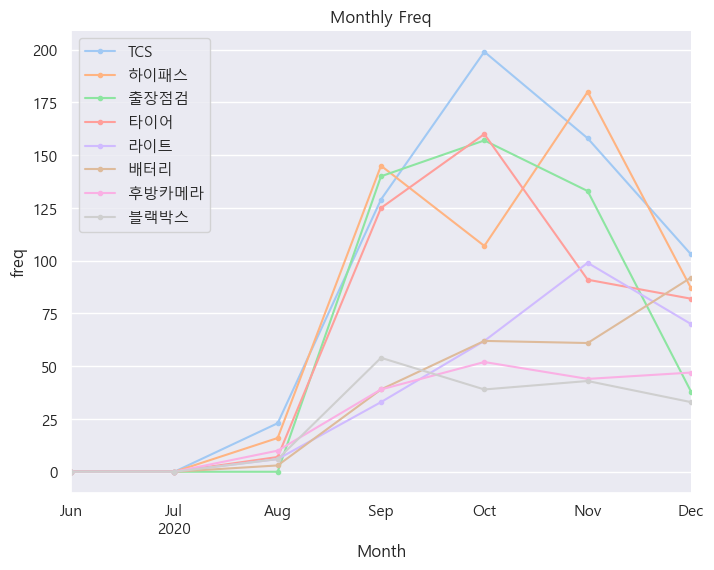

In [220]:
temp = pd.DataFrame()
for word, count in recategory_top20[2:10]:
    temp[word] = normal.groupby(pd.Grouper(key='dates', freq='M'))['recategory'].apply(lambda x: x[x == word].count())

temp.plot(marker='.')
plt.title('Monthly Freq')
plt.xlabel('Month')
plt.ylabel('freq')
plt.show()

* 8월말~12월초 까지의 데이터
* 장애처리 부분에서 recategory부분에서 '장애처리'라고 일괄처리 되어있는 항목 제외 시각화
* TCS,타이어,하이패스,라이트와 같이 소모품과 관련된 항목들은 출장점검과 같이 감소하는 추세를 보임
* 출장점검과 같이 감소하는 부분들은 해당문제 해결 후 일정기간 보장
* 12월의 데이터가 다른 월에 비해 갯수가 적음에도 불구하고 유일하게 치솟는 '배터리' 카테고리
* 쏘카 사업특성상 차량 장기 주차로 인한 배터리 문제
* 겨울철은 특히 배터리 수명이 짧아지는 시기이므로 배터리 장애문제가 급격하게 상승

In [221]:
# 배터리와 관련된 항목 추출
model.wv.most_similar('배터리', topn=10)

[('배터리점프', 0.6755704283714294),
 ('배터리교환', 0.663463830947876),
 ('배터리방전', 0.6488636136054993),
 ('배터리방전으로', 0.6023845672607422),
 ('후패드', 0.5463820695877075),
 ('전패드', 0.49607574939727783),
 ('시동유지', 0.4552147388458252),
 ('AGM', 0.4491885304450989),
 ('시동', 0.4216143786907196),
 ('점프시동', 0.40347209572792053)]

* '점프', '교환', '방전', '시동' 키워드
* 해당 부분들은 모두 장기주차로 인한 배터리 방전문제임
* 겨울철 배터리 방전 문제를 방지하기위한 대책필요
* 겨울철 비인기 차량에 대한 할인행사 필요
* 인원파견 혹은 쏘카존 주변 거주민들을 대상으로한 '일일도우미' 시스템을 만들어 차량의 주기적인 시동 필요
* '일일도우미' 인원들에 대해 현금 지급보단 쏘카 서비스를 이용할때 사용할 수 있는 '쏘카포인트' 제공
* 해당 부분과 현재 배터리교체 비용합계를 비교하여 회사에 손실이 적은 시스템을 도입하기 바람.

### Word2vec 사용하기

In [223]:
w2v_train = list(memo_data['subword_description'])
w2v_train = [line.split() for line in w2v_train]

model = gensim.models.word2vec.Word2Vec(w2v_train, vector_size=300, window=5, min_count=1, epochs=10)

In [224]:
model.wv.most_similar('타이어', topn=10)

[('전우타이어', 0.6425340175628662),
 ('앞타이어', 0.6054515242576599),
 ('전좌타이어', 0.5949205160140991),
 ('후좌타이어', 0.502559244632721),
 ('후우타이어', 0.5018349885940552),
 ('타이어펑크', 0.5011507272720337),
 ('바퀴', 0.4745725989341736),
 ('브레이크패드', 0.44834622740745544),
 ('펑크', 0.4462139904499054),
 ('휀다', 0.4437786340713501)]

In [225]:
model.wv.most_similar('경고등', topn=10)

[('엔진체크등', 0.7098898887634277),
 ('공기압경고등', 0.6713263392448425),
 ('고장코드', 0.644737184047699),
 ('통합경고등', 0.6066427826881409),
 ('기억', 0.5913510918617249),
 ('체크', 0.5664297938346863),
 ('라이트경고등', 0.5510396361351013),
 ('돔', 0.5078335404396057),
 ('과거', 0.5047518014907837),
 ('룸', 0.48080629110336304)]

In [227]:
# 매핑 테이블 작성
light = model.wv.most_similar('라이트', topn=20)
light_word = exclusion(light)
light = model.wv.most_similar('전구', topn=20)
light_word.extend(exclusion(light))

light_word.append('라이트')
light_word.append('전구')

light_word = set(light_word)

error = model.wv.most_similar('경고등', topn=10)
error_word = exclusion(error)
error_word.append('경고등')

mapping_table = {'내비게이션':'네비게이션', '내비':'네비게이션', '네비':'네비게이션', \
                  '딜리버리':'탁송', '탁송비':'탁송', \
                  '브레이크 오일':'브레이크액', '브레이크오일':'브레이크액', \
                  '라디오':'오디오', '블박':'블랙박스'}

light_mapping = dict()
for word in light_word:
    light_mapping[word] = '라이트'

mapping_table.update(light_mapping)

error_mapping = dict()
for word in error_word:
    error_mapping[word] = '경고등'

mapping_table.update(error_mapping)

print(mapping_table)

{'내비게이션': '네비게이션', '내비': '네비게이션', '네비': '네비게이션', '딜리버리': '탁송', '탁송비': '탁송', '브레이크 오일': '브레이크액', '브레이크오일': '브레이크액', '라디오': '오디오', '블박': '블랙박스', '라이트전구': '라이트', '하향등': '라이트', '데이라이트': '라이트', '실내등': '라이트', '브레이크전구': '라이트', '브레이크등': '라이트', '라이트': '라이트', '헤드라이트': '라이트', '안개등': '라이트', '전조등': '라이트', '라이트경고등': '라이트', '미등': '라이트', '후미등': '라이트', '방향지시등': '라이트', '주간주행등': '라이트', '주행등': '라이트', '전구': '라이트', '백색더블': '라이트', '엔진체크등': '경고등', '공기압경고등': '경고등', '고장코드': '경고등', '통합경고등': '경고등', '기억': '경고등', '경고등': '경고등'}


In [228]:
subword_list = []
for _, row in memo_data.iterrows():
    if row['inspect_type'] == '장애처리':
        car_words = find_category(row) 
    
        if len(car_words) >= 1: 
            subword_list.extend(car_words)

subword_list = [subword for subword in subword_list if subword != '']
subword_counter = Counter(subword_list) 
subword_sort = sorted(subword_counter.items(), key=lambda x:x[1], reverse=True)
subword_top20 = [(key, value) for key, value in subword_sort[:20]]

print(subword_top20)

[('장애처리', 1238), ('TCS', 613), ('하이패스', 543), ('타이어', 495), ('출장점검', 472), ('배터리', 273), ('후방카메라', 233), ('네비게이션', 216), ('블랙박스', 190), ('사고조사', 180), ('전조등', 129), ('전원', 120), ('컴파운드', 119), ('전구', 113), ('범퍼', 93), ('심', 86), ('도어', 84), ('제동등', 79), ('브레이크', 60), ('불량', 53)]


In [229]:
category_count = 0
recategory_count = 0
recategory = []
for _, row in memo_data.iterrows():
    if row['inspect_type'] == '장애처리':
        carWords = find_category(row) 
        recat = re_ranking(carWords)
        recategory.append(recat)
    
        category_count += 1
        if recat != None:
            recategory_count += 1 

    else:
        recategory.append(None)

memo_data['recategory'] = recategory 

memo_data = memo_data[['inspect_at', 'inspect_type','recategory','description','subword_description']]

memo_data.head()

,inspect_at,inspect_type,recategory,description,subword_description
0,2020-03-09,타이어수리(후우),None,조수석뒤타이어 현장펑크수리,조수석 뒤 타이어 현장 펑크수리
1,2020-01-07,미션오일,None,단양애니카_미션오일 교환,단 양 애 니 카 미션오일 교환
2,2020-01-14,점화플러그,None,당진세계모터스_점화플러그 교환,당진세계모터스 점화플러그 교환
3,2020-01-14,브레이크액,None,당진세계모터스-브레이크오일 교환,당진세계모터스 브레이크오일 교환
4,2020-01-06,브레이크액,None,당진세계모터스_브레이크오일 교환,당진세계모터스 브레이크오일 교환


In [230]:
recategory_counter = Counter(recategory)
recategory_counter_sorted = sorted(recategory_counter.items(), key=lambda x:x[1], reverse=True)
recategory_top20 = [(key, value) for key, value in recategory_counter_sorted[:21]]
print(recategory_top20)

[(None, 248668), ('장애처리', 1238), ('TCS', 612), ('하이패스', 535), ('출장점검', 468), ('타이어', 465), ('라이트', 285), ('배터리', 257), ('후방카메라', 192), ('블랙박스', 175), ('네비게이션', 167), ('사고조사', 167), ('컴파운드', 109), ('제동등', 71), ('범퍼', 64), ('도어', 62), ('브레이크', 50), ('시트', 37), ('전원', 36), ('볼', 32), ('와이퍼', 31)]


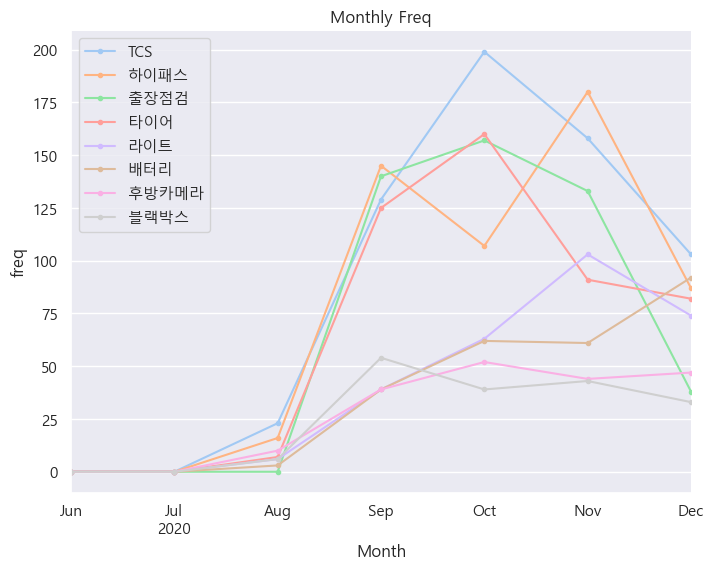

In [232]:
normal = memo_data.loc[memo_data['inspect_type'] == '장애처리'].copy()
normal['dates'] = pd.to_datetime(normal['inspect_at'], format='%Y-%m-%d', errors='raise')

temp = pd.DataFrame()
for word, count in recategory_top20[2:10]:
    temp[word] = normal.groupby(pd.Grouper(key='dates', freq='M'))['recategory'].apply(lambda x: x[x == word].count())

temp.plot(marker='.')
plt.title('Monthly Freq')
plt.xlabel('Month')
plt.ylabel('freq')
plt.show()

In [234]:
model.wv.most_similar('배터리', topn=10)

[('배터리교환', 0.4878200590610504),
 ('후패드', 0.4526918828487396),
 ('전패드', 0.4450978636741638),
 ('점화플러그', 0.4434347152709961),
 ('미션오일', 0.4285762906074524),
 ('브레이크액', 0.4228126108646393),
 ('배터리방전', 0.4157160818576813),
 ('시동', 0.4079366624355316),
 ('배터리방전으로', 0.3995799124240875),
 ('AGM', 0.37876778841018677)]

* word2vec 과 FastText 비교 결과 단어의 유사도를 뽑는과정에서는 차이가있었음
* 최종적 인사이트 도출을 위한 시각화 결과는 같은 결과가나옴

## 회고

---

* FastText 학습결과에서 단어가 분절되어 그대로 사용되는 경우를 발견하였으나 해결하지 못함
* 카테고리를 조합하는 과정이 매우 어렵게 느껴졌음
* 아직까지 자연어 처리과정에서의 응용단계는 힘듦
* 프로그램 작성보다는 시각화와 인사이트 도출에 집중함
* 자연어 처리 부분의 추가적인 학습 및 실습이 필요함
* 제공되어 있는 데이터에서 현업종사자가 아닌 이상 알아볼 수 없는 부분도 존재함
* 함수 정의 부분에서 정규표현식을 사용하면 작동이 되지 않는 상황도 발생함
* word2vec 과 TextFast 의 단어 유사도의 결과는 비슷하나 수치가 많이 다름
* 시각화를 하는 과정에서 두 모델의 결과가 같은게 오류의 일환인지 확인 필요함
* 이번 프로젝트는 주제 선정을 해주지 않고 스스로 하게 하여서 더욱 어렵게 느껴짐